# Calibración y reconstrucción 3D a partir de imágenes

In [ ]:
import cv2
import glob
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab.patches import cv2_imshow

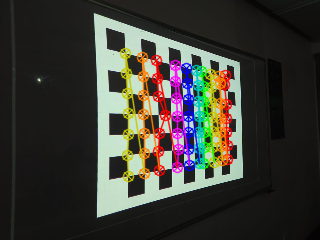

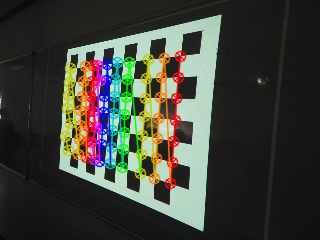

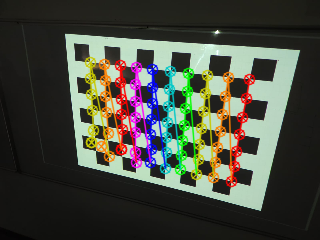

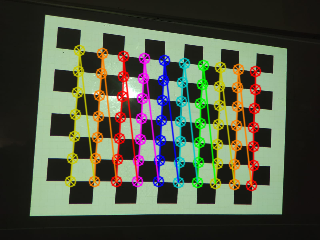

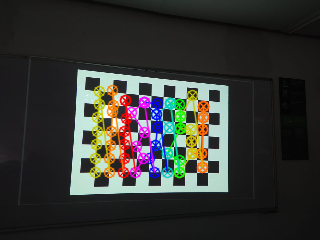

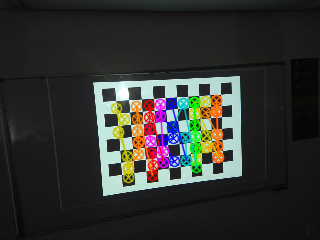

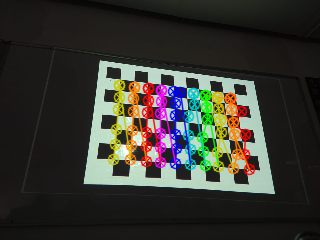

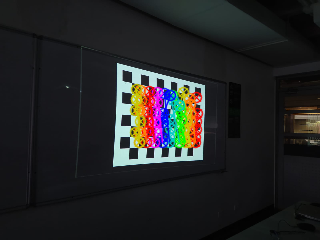

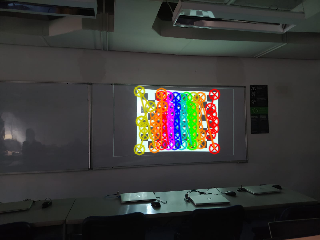

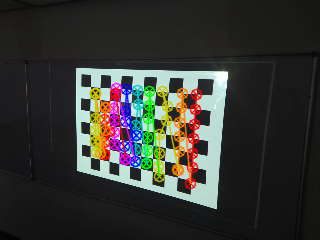

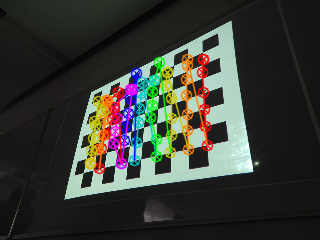

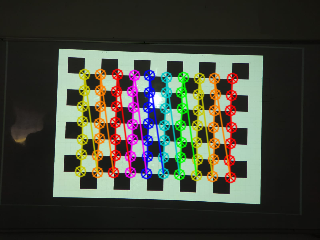

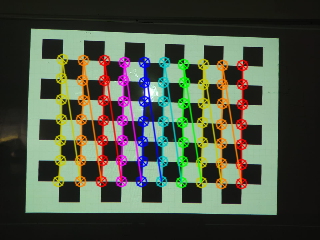

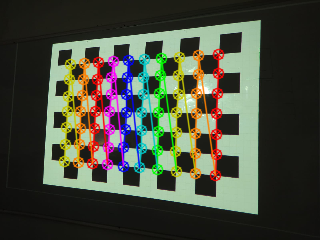

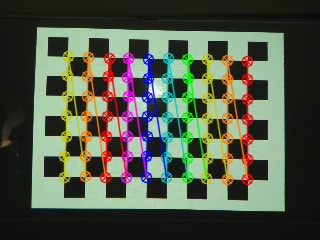

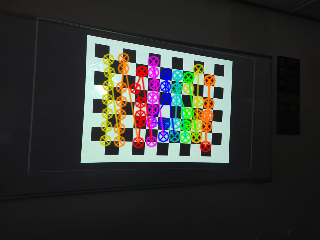

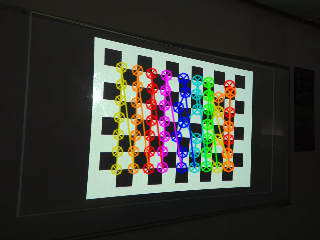

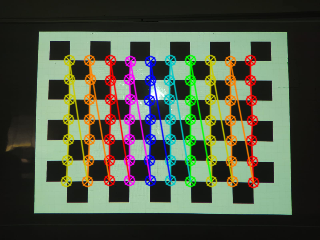

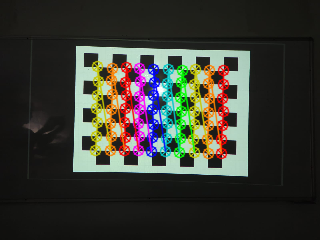

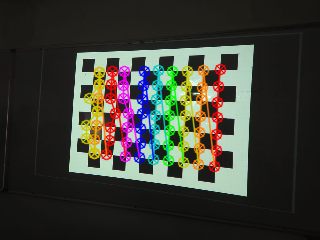

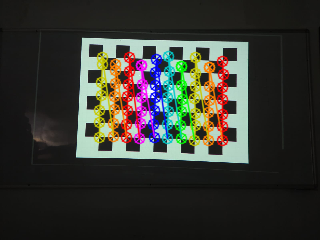

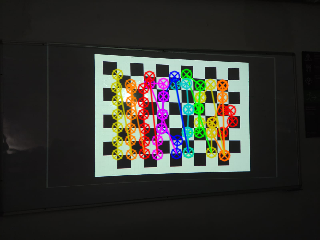

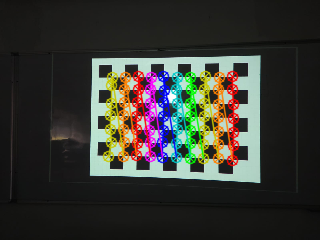

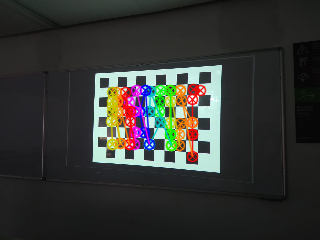

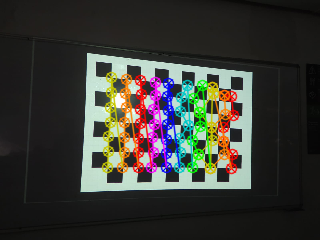

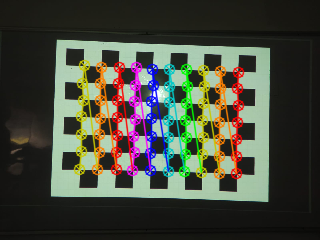

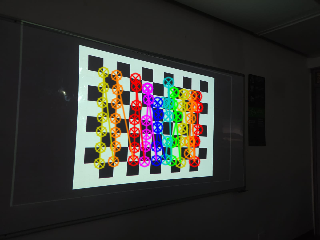

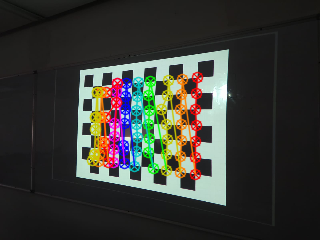

In [ ]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((7*10,3), np.float32)
objp[:,:2] = np.mgrid[0:10,0:7].T.reshape(-1,2)

objpoints = [] # Punto 3d en el espacio del mundo real.
imgpoints = [] # Puntos 2d en el plano de la imagen.

images = glob.glob('/content/drive/MyDrive/Computer_Vision/Semana 10/*.jpeg')

for fname in images:
 img = cv.imread(fname)
 img = cv.resize(img, (0,0), fx=0.2, fy=0.2)
 gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

 ret, corners = cv.findChessboardCorners(gray, (7,10), None)

 if ret == True:
  objpoints.append(objp)
  corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
  imgpoints.append(corners2)

 cv.drawChessboardCorners(img, (7,10), corners2, ret)
 cv2_imshow(img)

In [ ]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)
print(dist)

[[1.35461577e+03 0.00000000e+00 1.38507556e+02]
 [0.00000000e+00 2.62606466e+01 1.25167091e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 1.59073035  0.50173852 -1.13015632 -0.00294102 -0.15630919]]


In [ ]:
# Definir las constantes de la cámara
FX = 1.35461577e+03
FY = 2.62606466e+01
CX = 1.38507556e+02
CY = 1.25167091e+02

# Lista para almacenar las coordenadas de los puntos de cada par de imágenes
coordenadas_puntos = []

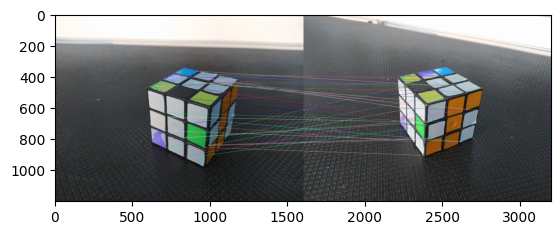

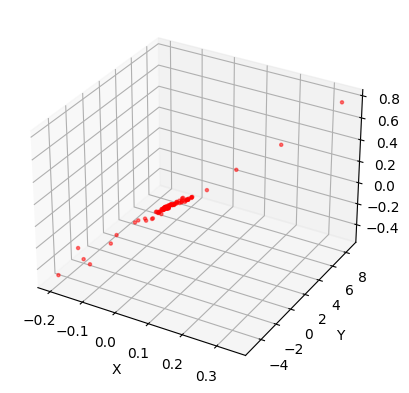

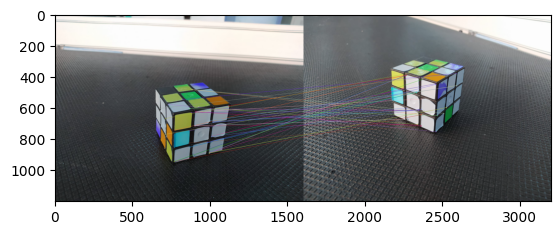

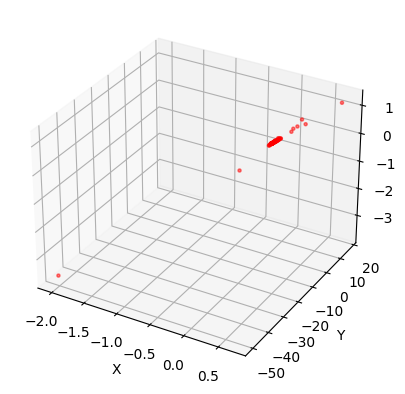

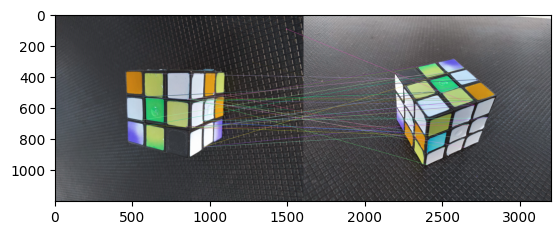

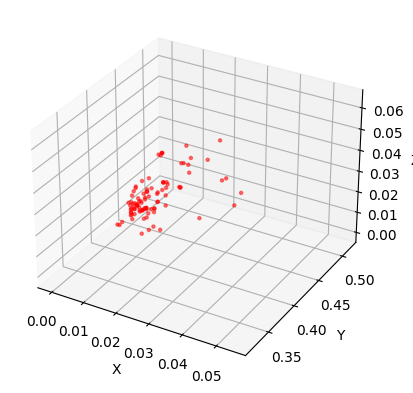

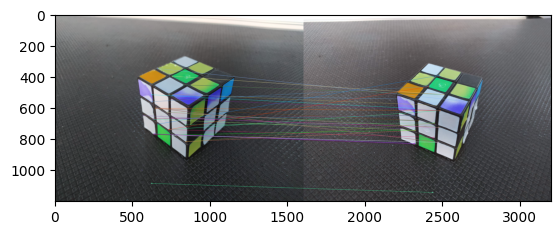

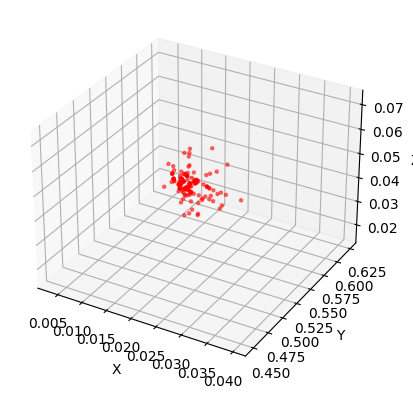

In [ ]:
# Define la función para dibujar y mostrar los emparejamientos
def draw_matches(img1, kp1, img2, kp2, matches, num_matches=40):
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:num_matches], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_matches)
    plt.show()

# Lista para almacenar las coordenadas 3D de los puntos
coordenadas_puntos = []

# Realiza el proceso 4 veces (para 8 imágenes)
for i in range(1, 5):
    img1 = cv2.imread(f'/content/drive/MyDrive/Computer_Vision/3D/Images_3D/Img_{2*i-1}.jpeg')
    img2 = cv2.imread(f'/content/drive/MyDrive/Computer_Vision/3D/Images_3D/Img_{2*i}.jpeg')

    K = np.array([[FX, 0, CX], [0, FY, CY], [0, 0, 1]])  # Matriz intrínseca de la cámara

    # Detección y emparejamiento de características
    orb = cv2.ORB_create()
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Mostrar los emparejamientos
    draw_matches(img1, kp1, img2, kp2, matches)

    # Matriz esencial
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

    _, R, t, _ = cv2.recoverPose(E, pts1, pts2, K, mask=mask)

    # Triangulación de puntos
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = np.hstack((R, t))

    P1 = K @ P1
    P2 = K @ P2

    points_4D = cv2.triangulatePoints(P1, P2, pts1, pts2)
    points_3D = points_4D / points_4D[3]  # Convertir de coordenadas homogéneas a Cartesianas
    points_3D = points_3D[:3, :].T

    coordenadas_puntos.append(points_3D)

    # Visualización
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], marker='o', s=5, c='r', alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

In [ ]:
# Imprimir la lista de coordenadas de los puntos para cada par de imágenes
print(coordenadas_puntos)

[array([[-1.82674855e-01, -3.23721075e+00, -3.26532006e-01],
       [-1.38759967e-02, -2.64826268e-01, -2.26677321e-02],
       [ 6.41523749e-02,  1.01465499e+00,  1.04141124e-01],
       [ 5.28847650e-02,  8.36888015e-01,  8.51539001e-02],
       [ 3.98023333e-03,  2.23539378e-02,  9.65004205e-04],
       [ 1.75855905e-02,  3.94721210e-01,  3.57480943e-02],
       [ 1.95991229e-02,  3.85079741e-01,  2.92909294e-02],
       [ 2.87605058e-02,  5.07288575e-01,  4.41367030e-02],
       [ 1.25379348e-02,  2.17682287e-01,  1.26216328e-02],
       [ 3.45247192e-03,  4.92689870e-02, -1.44177617e-03],
       [ 5.72219603e-02,  8.45247686e-01,  8.58963579e-02],
       [ 4.88992594e-03,  2.90994812e-02,  1.65365613e-03],
       [ 2.41854172e-02,  4.50396121e-01,  3.77809480e-02],
       [ 2.83253379e-02,  5.88204801e-01,  5.37132174e-02],
       [ 3.20364758e-02,  5.27575791e-01,  5.27098253e-02],
       [ 1.21238679e-02,  1.09025568e-01,  1.06293531e-02],
       [ 1.60116740e-02,  1.16473474e-0

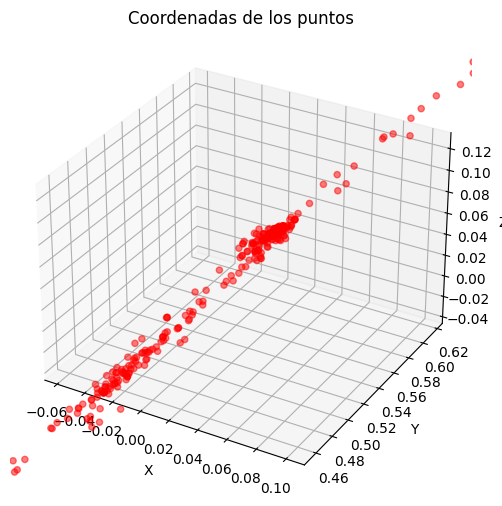

In [ ]:
# Visualizar todos los puntos juntos
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Iterar sobre cada conjunto de puntos
for puntos in coordenadas_puntos:
    # Graficar los puntos
    ax.scatter(puntos[:, 0], puntos[:, 1], puntos[:, 2], marker='o', s=20, c='r', alpha=0.5)

# Configurar etiquetas y título
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Coordenadas de los puntos')

# Configurar la relación de aspecto para que los ejes tengan la misma escala
max_range = np.array([np.max(puntos[:,0])-np.min(puntos[:,0]), np.max(puntos[:,1])-np.min(puntos[:,1]), np.max(puntos[:,2])-np.min(puntos[:,2])]).max() / 2.0
mid_x = (np.max(puntos[:,0]) + np.min(puntos[:,0])) * 0.5
mid_y = (np.max(puntos[:,1]) + np.min(puntos[:,1])) * 0.5
mid_z = (np.max(puntos[:,2]) + np.min(puntos[:,2])) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Mostrar la gráfica
plt.show()